In [ ]:
!python --version

Python 3.12.11


In [ ]:
!nvidia-smi

Sun Aug 31 07:11:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!cat /proc/meminfo | grep MemTotal

MemTotal:       53469676 kB


In [ ]:
import torch
print(torch.__version__)

2.8.0+cu126


In [ ]:
!pip install timm -q
!pip install einops
!pip install einops

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from einops.layers.torch import Rearrange
from google.colab import drive
import zipfile
from sklearn.model_selection import train_test_split
import shutil
import timm
import torch.nn as nn
import torch.fft
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import normalize
from torch.utils.data import DataLoader
import gc
from sklearn.metrics import roc_auc_score
import torch, numpy as np, pandas as pd
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc
)
import seaborn as sns

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset Loading and Exploration

In [ ]:
zip_path = "/content/drive/MyDrive/celeb-df-v2.zip"
extract_to = "/content/celeb-df-v2"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Done!")

✅ Done!


In [ ]:
real_path = os.path.join(extract_to, "Celeb-real")
synth_path = os.path.join(extract_to, "Celeb-synthesis")
yt_path = os.path.join(extract_to, "YouTube-real")

print("✅ Celeb-real:", len(os.listdir(real_path)), "files")
print("✅ Celeb-synthesis:", len(os.listdir(synth_path)), "files")
print("✅ YouTube-real:", len(os.listdir(yt_path)), "files")

✅ Celeb-real: 590 files
✅ Celeb-synthesis: 5639 files
✅ YouTube-real: 300 files


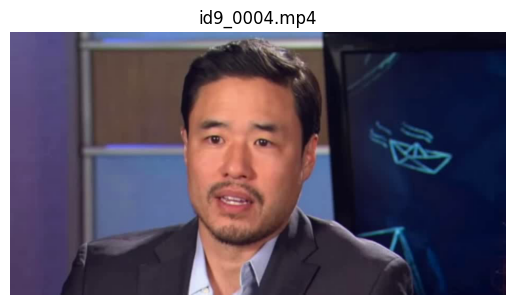

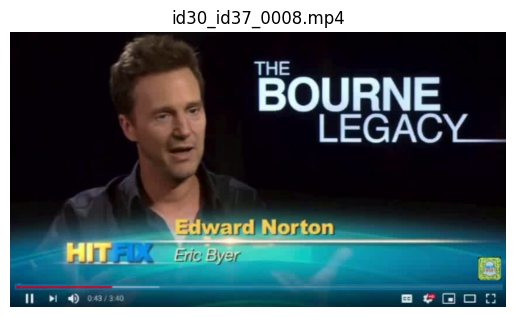

In [ ]:
def show_first_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        plt.axis('off')
        plt.title(os.path.basename(video_path))
        plt.show()
    else:
        print("⛔ Error reading:", video_path)

show_first_frame(os.path.join(real_path, os.listdir(real_path)[0]))
show_first_frame(os.path.join(synth_path, os.listdir(synth_path)[0]))

In [ ]:
def count_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return total

print("📽 Celeb-real (Number of frames):")
for vid in sorted(os.listdir(real_path))[:5]:
    print(vid, ":", count_frames(os.path.join(real_path, vid)))

print("\n📽 Celeb-synthesis (Number of frames):")
for vid in sorted(os.listdir(synth_path))[:5]:
    print(vid, ":", count_frames(os.path.join(synth_path, vid)))

📽 Celeb-real (Number of frames):
id0_0000.mp4 : 469
id0_0001.mp4 : 303
id0_0002.mp4 : 350
id0_0003.mp4 : 529
id0_0004.mp4 : 326

📽 Celeb-synthesis (Number of frames):
id0_id16_0000.mp4 : 469
id0_id16_0001.mp4 : 303
id0_id16_0002.mp4 : 350
id0_id16_0003.mp4 : 529
id0_id16_0004.mp4 : 326


In [ ]:
def get_size_in_mb(file_path):
    size = os.path.getsize(file_path) / (1024 * 1024)
    return round(size, 2)

print("📁 Celeb-real (File size):")
for vid in sorted(os.listdir(real_path))[:5]:
    print(vid, ":", get_size_in_mb(os.path.join(real_path, vid)), "MB")

print("\n📁 Celeb-synthesis (File size):")
for vid in sorted(os.listdir(synth_path))[:5]:
    print(vid, ":", get_size_in_mb(os.path.join(synth_path, vid)), "MB")

📁 Celeb-real (File size):
id0_0000.mp4 : 2.24 MB
id0_0001.mp4 : 1.54 MB
id0_0002.mp4 : 1.6 MB
id0_0003.mp4 : 2.14 MB
id0_0004.mp4 : 2.18 MB

📁 Celeb-synthesis (File size):
id0_id16_0000.mp4 : 2.1 MB
id0_id16_0001.mp4 : 1.47 MB
id0_id16_0002.mp4 : 1.51 MB
id0_id16_0003.mp4 : 2.05 MB
id0_id16_0004.mp4 : 2.13 MB


In [ ]:
def get_total_size(folder):
    return round(sum(get_size_in_mb(os.path.join(folder, f)) for f in os.listdir(folder)), 2)

print("🔹 Total size:")
print("  Celeb-real:", get_total_size(real_path), "MB")
print("  Celeb-synthesis:", get_total_size(synth_path), "MB")

🔹 Total size:
  Celeb-real: 902.66 MB
  Celeb-synthesis: 8115.02 MB


In [ ]:
def average_frame_count(directory):
    files = sorted(os.listdir(directory))
    counts = [count_frames(os.path.join(directory, f)) for f in tqdm(files)]
    return np.mean(counts), np.min(counts), np.max(counts)

mean_real, min_real, max_real = average_frame_count(real_path)
mean_fake, min_fake, max_fake = average_frame_count(synth_path)

print("🎯 Celeb-real:", f"Average={mean_real:.1f}, Min={min_real}, Max={max_real}")
print("🎯 Celeb-synthesis:", f"Average={mean_fake:.1f}, Min={min_fake}, Max={max_fake}")

100%|██████████| 5639/5639 [00:05<00:00, 1063.26it/s]

🎯 Celeb-real: Average=382.0, Min=1, Max=740
🎯 Celeb-synthesis: Average=375.4, Min=105, Max=740


In [ ]:
def average_frame_count(directory, min_valid=10):
    files = sorted(os.listdir(directory))
    counts = [count_frames(os.path.join(directory, f)) for f in tqdm(files)]

    counts = [c for c in counts if c >= min_valid]

    return np.mean(counts), np.min(counts), np.max(counts)

mean_real, min_real, max_real = average_frame_count(real_path)
mean_fake, min_fake, max_fake = average_frame_count(synth_path)

print("🎯 Celeb-real:", f"Average={mean_real:.1f}, Min={min_real}, Max={max_real}")
print("🎯 Celeb-synthesis:", f"Average={mean_fake:.1f}, Min={min_fake}, Max={max_fake}")

100%|██████████| 5639/5639 [00:05<00:00, 1085.76it/s]

🎯 Celeb-real: Average=382.7, Min=145, Max=740
🎯 Celeb-synthesis: Average=375.4, Min=105, Max=740


# Data Preprocessing & Making New Dataset

In [ ]:
# ===============================
# Settings for preprocessing
# ===============================
IMG_SIZE = 224
FRAMES_PER_VIDEO = 10
OUTPUT_DIR_BASE = "/content/dataset"
os.makedirs(OUTPUT_DIR_BASE, exist_ok=True)

# Transform: prepare RGB frame for PyTorch
rgb_transform_base = transforms.Compose([
    transforms.ToTensor(),
])

# ==========================================
# Extract evenly spaced frames from a video
# ==========================================
def extract_middle_frames_base(video_path, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        cap.release()
        return []

    idxs = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)
    frames = []
    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    cap.release()
    return frames

# ==========================================
# Convert grayscale image into FFT channels
# ==========================================
def get_fft_channels_base(gray_img):
    fft = np.fft.fft2(gray_img)
    fft_shift = np.fft.fftshift(fft)     # Move low frequencies to the center
    real = np.real(fft_shift)
    imag = np.imag(fft_shift)
    return np.stack([real, imag], axis=0)

# ==========================================
# Process one video and save it as .npz file
# ==========================================
def process_and_save_base(video_path, label, split, cls_name, index):
    frames = extract_middle_frames_base(video_path, FRAMES_PER_VIDEO)  # Get 10 frames

    rgb_data = []
    fft_data = []

    for frame in frames:
        rgb = rgb_transform_base(frame).numpy()
        gray = cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2GRAY)
        fft = get_fft_channels_base(gray)
        rgb_data.append(rgb)
        fft_data.append(fft)

    rgb_data = np.stack(rgb_data)   # Shape: [T, C, H, W] for RGB
    fft_data = np.stack(fft_data)   # Shape: [T, 2, H, W] for FFT

    save_dir = os.path.join(OUTPUT_DIR_BASE, split, cls_name)
    os.makedirs(save_dir, exist_ok=True)

    out_path = os.path.join(save_dir, f"{index:05d}.npz")
    np.savez_compressed(out_path, rgb=rgb_data, fft=fft_data, label=label)

# ==========================================
# Process all videos in a folder
# ==========================================
def process_folder_base(video_list, label, split, cls_name):
    for idx, video_path in enumerate(tqdm(video_list)):
        process_and_save_base(video_path, label, split, cls_name, idx)

In [ ]:
real_videos = sorted(glob("/content/celeb-df-v2/Celeb-real/*.mp4"))[:590]
fake_videos = sorted(glob("/content/celeb-df-v2/Celeb-synthesis/*.mp4"))[:590]

all_videos = real_videos + fake_videos
all_labels = [0]*len(real_videos) + [1]*len(fake_videos)

train_videos, temp_videos, train_labels, temp_labels = train_test_split(
    all_videos, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

val_videos, test_videos, val_labels, test_labels = train_test_split(
    temp_videos, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

def split_by_label(videos, labels):
    real = [v for v, l in zip(videos, labels) if l == 0]
    fake = [v for v, l in zip(videos, labels) if l == 1]
    return real, fake

train_real, train_fake = split_by_label(train_videos, train_labels)
val_real, val_fake = split_by_label(val_videos, val_labels)
test_real, test_fake = split_by_label(test_videos, test_labels)

for split_name, real_videos_split, fake_videos_split in [
    ("train", train_real, train_fake),
    ("val",   val_real,   val_fake),
    ("test",  test_real,  test_fake),
]:
    print(f"\n📦 [Baseline] Processing {split_name.upper()} set")

    print(f"🔁 Baseline {split_name}/real")
    process_folder_base(real_videos_split, label=0, split=split_name, cls_name="real")

    print(f"🔁 Baseline {split_name}/fake")
    process_folder_base(fake_videos_split, label=1, split=split_name, cls_name="fake")

print("\n✅ Balanced dataset created at: /content/dataset/")


📦 [Baseline] Processing TRAIN set
🔁 Baseline train/real


100%|██████████| 413/413 [05:12<00:00,  1.32it/s]


🔁 Baseline train/fake


100%|██████████| 413/413 [05:16<00:00,  1.30it/s]



📦 [Baseline] Processing VAL set
🔁 Baseline val/real


100%|██████████| 88/88 [01:06<00:00,  1.33it/s]


🔁 Baseline val/fake


100%|██████████| 89/89 [01:09<00:00,  1.27it/s]



📦 [Baseline] Processing TEST set
🔁 Baseline test/real


100%|██████████| 89/89 [01:06<00:00,  1.33it/s]


🔁 Baseline test/fake


100%|██████████| 88/88 [01:08<00:00,  1.28it/s]


✅ Balanced dataset created at: /content/dataset/


In [ ]:
print("📊 Train:", len(train_real), "real,", len(train_fake), "fake")
print("📊 Val:", len(val_real), "real,", len(val_fake), "fake")
print("📊 Test:", len(test_real), "real,", len(test_fake), "fake")

📊 Train: 413 real, 413 fake
📊 Val: 88 real, 89 fake
📊 Test: 89 real, 88 fake


🔍 Keys: ['rgb', 'fft', 'label']
📐 Shapes → rgb: (10, 3, 224, 224) , fft: (10, 2, 224, 224) , label: 0


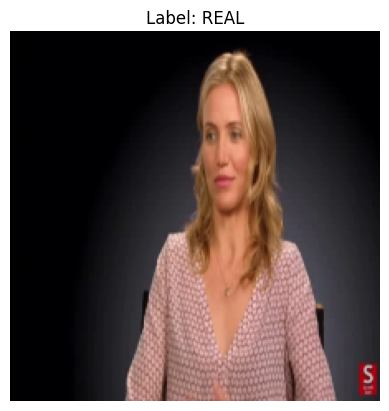

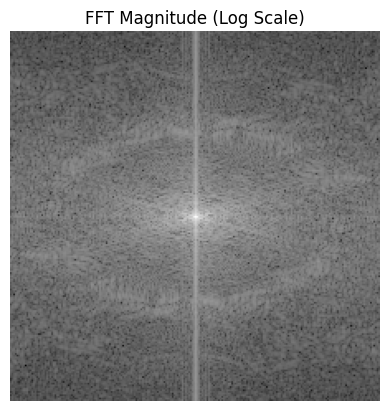

In [ ]:
sample_file = "/content/dataset/train/real/00000.npz"

data = np.load(sample_file)

print("🔍 Keys:", list(data.keys()))
print("📐 Shapes → rgb:", data['rgb'].shape, ", fft:", data['fft'].shape, ", label:", data['label'])

plt.imshow(np.transpose(data['rgb'][0], (1, 2, 0)))
plt.title(f"Label: {'REAL' if data['label']==0 else 'FAKE'}")
plt.axis('off')
plt.show()

fft_real = data['fft'][0][0]
fft_imag = data['fft'][0][1]
fft_mag = np.sqrt(fft_real**2 + fft_imag**2)

plt.imshow(np.log(fft_mag + 1), cmap='gray')
plt.title("FFT Magnitude (Log Scale)")
plt.axis('off')
plt.show()

In [ ]:
broken_files = []

def check_shape(path):
    """
    Check if a saved .npz file has the expected arrays and shapes:
      - data["rgb"] should be (10, 3, 224, 224)
      - data["fft"] should be (10, 2, 224, 224)
    Return True if OK; return False if shape is wrong or file can't be read.
    """
    try:
        data = np.load(path)
        if data["rgb"].shape != (10, 3, 224, 224):
            return False
        if data["fft"].shape != (10, 2, 224, 224):
            return False
        return True
    except:
        return False

for split in ["train", "val", "test"]:
    for cls in ["real", "fake"]:
        folder = f"/content/dataset/{split}/{cls}"
        for fname in os.listdir(folder):
            if fname.endswith(".npz"):
                path = os.path.join(folder, fname)
                if not check_shape(path):
                    broken_files.append(path)

print("❌ Number of broken files:", len(broken_files))
if broken_files:
    print("📂 Example:", broken_files[:5])

❌ Number of broken files: 1
📂 Example: ['/content/dataset/train/real/00109.npz']


In [ ]:
for path in broken_files:
    os.remove(path)
print("✅ Broken baseline files have been removed.")

✅ Broken baseline files have been removed.


In [ ]:
!zip -r /content/dataset_ready.zip /content/dataset

!cp /content/dataset_ready.zip /content/drive/MyDrive/M2TR-dataset/
print("📦 Baseline dataset saved to Google Drive → dataset_ready.zip")

# Loading New Dataset

In [ ]:
zip_path_base = "/content/drive/MyDrive/M2TR-dataset/dataset_ready.zip"
extract_to_base = "/content/dataset"

with zipfile.ZipFile(zip_path_base, 'r') as zip_ref:
    zip_ref.extractall(extract_to_base)

print("✅ Baseline dataset has been extracted.")

✅ Baseline dataset has been extracted.


In [ ]:
src = "/content/dataset/content/dataset"
dst = "/content/dataset"

shutil.move(src + "/train", dst + "/train")
shutil.move(src + "/val", dst + "/val")
shutil.move(src + "/test", dst + "/test")

shutil.rmtree("/content/dataset/content")
print("✅ Paths have been fixed.")

✅ Paths have been fixed.


In [ ]:
for root, dirs, files in os.walk("/content/dataset"):
    print("📁", root)
    for d in dirs:
        print("   └──", d)
    break

📁 /content/dataset
   └── val
   └── train
   └── test


In [ ]:
train_path = "/content/dataset/train"
for root, dirs, files in os.walk(train_path):
    print("📁", root)
    for d in dirs:
        print("   └──", d)
    for f in files:
        print("   📄", f)
    break

📁 /content/dataset/train
   └── fake
   └── real


In [ ]:
base_path = "/content/dataset"

for split in ["train", "val", "test"]:
    print(f"\n📁 {split.upper()}")
    for cls in ["real", "fake"]:
        folder = os.path.join(base_path, split, cls)
        if os.path.exists(folder):
            npz_files = [f for f in os.listdir(folder) if f.endswith(".npz")]
            print(f"   └── {cls} ({len(npz_files)} File)")


📁 TRAIN
   └── real (412 File)
   └── fake (413 File)

📁 VAL
   └── real (88 File)
   └── fake (89 File)

📁 TEST
   └── real (89 File)
   └── fake (88 File)


# M2TR Model

In [ ]:
class EfficientNetFeatureExtractor(nn.Module):
    def __init__(self, model_name='efficientnet_b4', output_dim=512):
        super().__init__()
        # Pretrained EfficientNet backbone without classifier head
        self.backbone = timm.create_model(model_name, pretrained=True, features_only=True)

        # Channel count of the last feature map (≈1792 for EfficientNet-B4 at 224x224).
        last_ch = self.backbone.feature_info[-1]['num_chs']

        # 1x1 conv to map last_ch → output_dim (keeps spatial size, changes only channels).
        self.project = nn.Conv2d(in_channels=last_ch, out_channels=output_dim, kernel_size=1)

    def forward(self, x):
        # Run the image through the backbone and take the final (deepest) feature map.
        feats = self.backbone(x)[-1]      # Shape ≈ [B, last_ch, 7, 7] for 224x224 inputs

        # Project channels to output_dim; spatial resolution stays the same.
        return self.project(feats)        # Shape: [B, output_dim, H', W']

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, embed_dim=512, patch_size=16):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        # Conv with kernel=stride=patch_size → extract non-overlapping patches & project to embed_dim
        self.proj = nn.Conv2d(in_channels, embed_dim,
                              kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # Input: [B, C, H, W]
        x = self.proj(x)                    # -> [B, D, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)    # [B, N, D]
        return x

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=10000):
        super(PositionalEncoding, self).__init__()
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.pe_dict = {}

    def forward(self, x):
        B, N, D = x.size()
        if N not in self.pe_dict:
            pe = torch.zeros(N, D, device=x.device)
            position = torch.arange(0, N, dtype=torch.float, device=x.device).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, D, 2, device=x.device).float() * (-np.log(10000.0) / D))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            self.pe_dict[N] = pe
        pe = self.pe_dict[N]
        return x + pe.unsqueeze(0)

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout_mlp=0.4, dropout_attn=0.1):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_attn, batch_first=True)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout_mlp),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout_mlp)
        )

    def forward(self, x):
        x_norm = self.norm1(x)
        attn_output, _ = self.attn(x_norm, x_norm, x_norm)  # Self-attention
        x = x + attn_output

        x = x + self.mlp(self.norm2(x))                # Pre-norm + MLP + residual
        return x                                       # [B, N, D]

In [ ]:
class MultiScaleTransformerEncoder(nn.Module):
    """
    Input:  x of shape [B, D, H, W]
    Output: tensor of shape [B, D] (multi-scale fused representation)
    """
    def __init__(self, embed_dim=512, num_heads=8, depth=4, grids=(7, 3, 1)):
        super().__init__()
        self.grids = grids

        def make_branch():
            blocks = []
            for _ in range(depth):
                blocks.append(TransformerBlock(embed_dim, num_heads))
            return nn.Sequential(*blocks)

        # One Transformer branch per scale
        self.branches = nn.ModuleList([make_branch() for _ in grids])

        self.pe = PositionalEncoding(embed_dim)

    def forward(self, x):
        B, D, H, W = x.shape
        pooled_feats = []

        for (g, branch) in zip(self.grids, self.branches):
            px = nn.functional.adaptive_avg_pool2d(x, output_size=(g, g))
            px = px.flatten(2).transpose(1, 2)
            px = self.pe(px)
            px = branch(px)
            pooled_feats.append(px.mean(dim=1))

        return torch.stack(pooled_feats, dim=0).mean(dim=0) # fused [B, D]

In [ ]:
class CMFBlock(nn.Module):
    def __init__(self, embed_dim):
        super(CMFBlock, self).__init__()
        # 1x1 Conv1d projection
        self.q_conv = nn.Conv1d(embed_dim, embed_dim, kernel_size=1)
        self.k_conv = nn.Conv1d(embed_dim, embed_dim, kernel_size=1)
        self.v_conv = nn.Conv1d(embed_dim, embed_dim, kernel_size=1)

        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=8, batch_first=True)

        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, rgb_feat, fft_feat):
        # Inputs: [B*T, D] → reshape to [B*T, 1, D]
        rgb_feat = rgb_feat.unsqueeze(1)
        fft_feat = fft_feat.unsqueeze(1)

        # Conv1d projections
        Q = self.q_conv(rgb_feat.transpose(1, 2)).transpose(1, 2)  # Queries  from RGB
        K = self.k_conv(fft_feat.transpose(1, 2)).transpose(1, 2)  # Keys     from FFT
        V = self.v_conv(fft_feat.transpose(1, 2)).transpose(1, 2)  # Values   from FFT

        # Cross-attention
        attn_output, _ = self.attn(Q, K, V)

        # Output: [B*T, D]
        fused = self.out_proj(attn_output.squeeze(1))
        return fused

In [ ]:
class LearnableFrequencyFilter(nn.Module):
    def __init__(self, img_size=224):
        super().__init__()
        # Trainable frequency mask (H×W), init=1 → pass-through
        self.freq_mask = nn.Parameter(torch.ones(1, 1, img_size, img_size))

    def forward(self, x_fft):
        # Input: [B, 2, H, W] (real & imag, fftshifted)
        real = x_fft[:, 0, :, :]
        imag = x_fft[:, 1, :, :]
        spec = torch.complex(real, imag)

        # Apply learnable mask
        mask = torch.clamp(self.freq_mask, 0.0, 1.0)
        spec_f = spec * mask.squeeze(1)

        # Invert to spatial domain: undo shift → inverse FFT → take real part
        spec_unshift = torch.fft.ifftshift(spec_f, dim=(-2, -1))  # center → corners
        spatial = torch.fft.ifft2(spec_unshift).real              # [B, H, W]

        # Repeat to 3 channels (RGB-like)
        return spatial.unsqueeze(1).repeat(1, 3, 1, 1)            # [B, 3, H, W]

In [ ]:
class M2TRBackbone(nn.Module):
    def __init__(self, embed_dim=512, depth=4, num_heads=8):
        super(M2TRBackbone, self).__init__()

        # RGB and FFT encoders (EfficientNet features projected to embed_dim)
        self.rgb_encoder = EfficientNetFeatureExtractor(output_dim=embed_dim)
        self.fft_encoder = EfficientNetFeatureExtractor(output_dim=embed_dim)

        # Multi-scale Transformer encoders for each stream
        self.rgb_blocks = MultiScaleTransformerEncoder(embed_dim=embed_dim, num_heads=num_heads, depth=depth)
        self.fft_blocks = MultiScaleTransformerEncoder(embed_dim=embed_dim, num_heads=num_heads, depth=depth)

        # Cross-Modality Fusion (uses RGB as Q, FFT as K/V)
        self.cmf = CMFBlock(embed_dim=embed_dim)

        # Learnable mask in frequency domain to filter FFT inputs
        self.learnable_fft_filter = LearnableFrequencyFilter(img_size=224)

    def forward(self, rgb, fft):
        B, T, C, H, W = rgb.shape  # rgb: [B,T,3,H,W], fft: [B,T,2,H,W]

        # Merge batch and time so we can process frames independently
        rgb = rgb.view(B * T, C, H, W)      # -> [B*T, 3, H, W]
        fft = fft.view(B * T, 2, H, W)      # -> [B*T, 2, H, W]

        # Apply the learnable frequency filter to the FFT spectrum,
        # then expand to 3 channels so the CNN backbone can consume it
        fft = self.learnable_fft_filter(fft)  # [B*T, 3, H, W]

        # CNN feature extraction (spatial maps, e.g., ~7x7)
        rgb_feat = self.rgb_encoder(rgb)      # [B*T, D, H', W']
        fft_feat = self.fft_encoder(fft)      # [B*T, D, H', W']

        # Multi-scale Transformer encoding → one vector per frame
        rgb_feat = self.rgb_blocks(rgb_feat)  # [B*T, D]
        fft_feat = self.fft_blocks(fft_feat)  # [B*T, D]

        # Cross-modality fusion (RGB ↔ FFT) → fused per-frame embedding
        fused = self.cmf(rgb_feat, fft_feat)  # [B*T, D]

        # Restore batch and time dimensions
        fused = fused.view(B, T, -1)          # [B, T, D]
        return fused

In [ ]:
class ClassificationHead(nn.Module):
    def __init__(self, embed_dim=512, dropout=0.4):
        super(ClassificationHead, self).__init__()
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),   # normalize before linear
            nn.Dropout(dropout),       # regularization
            nn.Linear(embed_dim, 1)    # map D → 1 (logit)
        )

    def forward(self, x):
        # If input is [B, T, D], pool first: x = x.mean(dim=1)
        x = self.classifier(x)         # [B, D] → [B, 1]
        return x.squeeze(1)            # [B, 1] → [B]

In [ ]:
class TemporalTransformer(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8, depth=2, dropout=0.1):
        super(TemporalTransformer, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

    def forward(self, x):
        # Input: [B, T, D]
        return self.transformer(x)   # Output: [B, T, D]

In [ ]:
class M2TRModelWithTemporal(nn.Module):
    def __init__(self, embed_dim=512, depth=4, num_heads=8, temporal_depth=2):
        super(M2TRModelWithTemporal, self).__init__()
        # Per-frame dual-stream backbone
        self.backbone = M2TRBackbone(embed_dim=embed_dim, depth=depth, num_heads=num_heads)
        # Temporal encoder across frames
        self.temporal = TemporalTransformer(embed_dim=embed_dim, num_heads=num_heads, depth=temporal_depth)
        # Binary classifier
        self.classifier = ClassificationHead(embed_dim=embed_dim)

    def forward(self, rgb, fft, return_features=False):
        # Inputs: rgb [B,T,3,H,W], fft [B,T,2,H,W]
        features = self.backbone(rgb, fft)            # [B, T, D]
        temporal_features = self.temporal(features)   # [B, T, D]
        pooled = temporal_features.mean(dim=1)        # [B, D]
        out = self.classifier(pooled)                 # [B]

        if return_features:
            return out, pooled
        else:
            return out

In [ ]:
def contrastive_loss(features, labels, margin=1.0):
    # L2-normalize features
    features = F.normalize(features, p=2, dim=1)
    B = features.size(0)

    # Pairwise Euclidean distance matrix
    dist_matrix = torch.cdist(features, features, p=2)  # [B, B]

    # Same-class and different-class masks
    labels = labels.view(-1, 1)
    same = (labels == labels.T).float()
    diff = 1 - same

    # Losses
    same_loss = (dist_matrix.pow(2) * same).sum()
    diff_loss = (F.relu(margin - dist_matrix).pow(2) * diff).sum()

    # Normalize by number of pairs
    num_pairs = same.sum() + diff.sum()
    total_loss = (same_loss + diff_loss) / (num_pairs + 1e-8)
    return total_loss

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device,
                    epoch, contrastive_weight=0.05, max_grad_norm=5.0):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    running_main_loss, running_contrast_loss = 0.0, 0.0

    for rgb, fft, labels in dataloader:

        rgb, fft, labels = rgb.to(device), fft.to(device), labels.to(device).float()

        optimizer.zero_grad()

        # Contrastive warm-up for first 3 epochs
        if epoch < 3 and contrastive_weight > 0:
            outputs, features = model(rgb, fft, return_features=True)  # outputs: [B], features: [B, D]
            loss_main = criterion(outputs, labels)
            loss_contrast = contrastive_loss(features, labels)
            loss = loss_main + contrastive_weight * loss_contrast

            running_main_loss += loss_main.item() * labels.size(0)
            running_contrast_loss += loss_contrast.item() * labels.size(0)
        else:
            outputs = model(rgb, fft)
            loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        # Metrics
        running_loss += loss.item() * labels.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    # Epoch metrics
    avg_loss = running_loss / total
    accuracy = correct / total
    avg_main_loss = running_main_loss / total if epoch < 3 else None
    avg_contrast_loss = running_contrast_loss / total if epoch < 3 else None

    return {
        "loss": avg_loss,
        "acc": accuracy,
        "main_loss": avg_main_loss,
        "contrastive_loss": avg_contrast_loss
    }

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for rgb, fft, labels in dataloader:
            rgb, fft, labels = rgb.to(device), fft.to(device), labels.to(device).float()

            outputs = model(rgb, fft)      # logits: [B]
            loss = criterion(outputs, labels)

            probs = torch.sigmoid(outputs)         # [B], values in [0, 1]
            preds = (probs > 0.5).long()           # threshold at 0.5 → 0/1

            running_loss += loss.item() * labels.size(0)
            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())
            all_probs.extend(probs.cpu().numpy().tolist())

    avg_loss = running_loss / total
    accuracy = correct / total

    return {
        "loss": avg_loss,
        "acc": accuracy,
        "labels": all_labels,
        "preds": all_preds,
        "probs": all_probs
    }

In [ ]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    best_epoch = val_accs.index(max(val_accs)) + 1  # +1 because epochs are 1-based

    plt.figure(figsize=(10, 4))

    # 📉 Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'o-b', label='Training Loss')
    plt.plot(epochs, val_losses, 's-r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # 🎯 Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'o-g', label='Training Accuracy')
    plt.plot(epochs, val_accs, 's-m', label='Validation Accuracy')
    plt.axvline(x=best_epoch, linestyle="--", color="gray", label=f'Best Epoch: {best_epoch}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("📦 Using device:", device)

model = M2TRModelWithTemporal(embed_dim=512, depth=4, num_heads=8).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Cosine Annealing Learning Rate scheduler: smoothly decays LR over T_max epochs
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

📦 Using device: cuda


In [ ]:
class VideoDataset(Dataset):
    def __init__(self, root_dir, classes=["real", "fake"], normalize_rgb=True):
        """
        Args:
            root_dir (str): Path to split folder, e.g. "/content/dataset/train".
            classes (list): Subfolders to read, e.g. ["real", "fake"].
            normalize_rgb (bool): If True, apply ImageNet mean/std to RGB frames.
        """
        self.samples = []
        self.normalize_rgb = normalize_rgb
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        self.std  = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

        for label, cls_name in enumerate(classes):
            cls_path = os.path.join(root_dir, cls_name)
            if not os.path.exists(cls_path):
                continue
            for file_name in os.listdir(cls_path):
                if file_name.endswith(".npz"):
                    file_path = os.path.join(cls_path, file_name)
                    self.samples.append((file_path, label))

        np.random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        data = np.load(path)

        rgb = torch.tensor(data["rgb"], dtype=torch.float32)  # [T, 3, H, W]
        fft = torch.tensor(data["fft"], dtype=torch.float32)  # [T, 2, H, W]

        if self.normalize_rgb:
            rgb = (rgb - self.mean) / self.std

        label = torch.tensor(label, dtype=torch.long)
        return rgb, fft, label

In [ ]:
base_path = "/content/dataset"

train_dataset = VideoDataset(os.path.join(base_path, "train"))
val_dataset   = VideoDataset(os.path.join(base_path, "val"))
test_dataset  = VideoDataset(os.path.join(base_path, "test"))

batch_size  = 2
num_workers = 2

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=True, drop_last=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True
)

try:
    _ = next(iter(test_loader))
    print(f"✅ loaders ready | train:{len(train_dataset)} val:{len(val_dataset)} test:{len(test_dataset)}")
except Exception as e:
    print("⚠️ DataLoader error, retrying with num_workers=0 ...", e)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=0, pin_memory=True, drop_last=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=0, pin_memory=True
    )
    _ = next(iter(test_loader))
    print("✅ loaders rebuilt with num_workers=0")

✅ loaders ready | train:825 val:177 test:177


In [ ]:
sample_rgb, sample_fft, sample_label = next(iter(train_loader))

print("🔹 RGB shape:", sample_rgb.shape)
print("🔹 FFT shape:", sample_fft.shape)
print("🔹 Labels:", sample_label)

🔹 RGB shape: torch.Size([2, 10, 3, 224, 224])
🔹 FFT shape: torch.Size([2, 10, 2, 224, 224])
🔹 Labels: tensor([1, 0])


# Baseline Model

In [ ]:
num_epochs = 15
best_val_auc = 0.0   # Track best validation AUC to pick the best model

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

for epoch in range(num_epochs):
    print(f"\n📘 Epoch {epoch+1}/{num_epochs} — LR: {optimizer.param_groups[0]['lr']:.6f}")

    train_metrics = train_one_epoch(
        model, train_loader, criterion, optimizer, device,
        epoch, contrastive_weight=0.0
    )

    val_metrics = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_metrics["loss"])
    val_losses.append(val_metrics["loss"])
    train_accs.append(train_metrics["acc"])
    val_accs.append(val_metrics["acc"])

    print(f"  🔹 Train Loss: {train_metrics['loss']:.4f} | Acc: {train_metrics['acc']:.4f}")
    print(f"  🔸 Val   Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['acc']:.4f}")

    val_auc = roc_auc_score(val_metrics["labels"], val_metrics["probs"])
    print(f"  🔸 Val   AUC : {val_auc:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved (by AUC).")

    # scheduler.step()

    torch.cuda.empty_cache()
    gc.collect()


📘 Epoch 1/15 — LR: 0.000100
  🔹 Train Loss: 0.7945 | Acc: 0.6153
  🔸 Val   Loss: 0.5511 | Acc: 0.8249
  🔸 Val   AUC : 0.8558
✅ Best model saved (by AUC).

📘 Epoch 2/15 — LR: 0.000100
  🔹 Train Loss: 0.6224 | Acc: 0.7500
  🔸 Val   Loss: 0.5551 | Acc: 0.8249
  🔸 Val   AUC : 0.8876
✅ Best model saved (by AUC).

📘 Epoch 3/15 — LR: 0.000100
  🔹 Train Loss: 0.5408 | Acc: 0.8022
  🔸 Val   Loss: 0.5408 | Acc: 0.8305
  🔸 Val   AUC : 0.8842

📘 Epoch 4/15 — LR: 0.000100
  🔹 Train Loss: 0.5249 | Acc: 0.8216
  🔸 Val   Loss: 0.5424 | Acc: 0.8362
  🔸 Val   AUC : 0.8971
✅ Best model saved (by AUC).

📘 Epoch 5/15 — LR: 0.000100
  🔹 Train Loss: 0.4188 | Acc: 0.8556
  🔸 Val   Loss: 0.5909 | Acc: 0.8362
  🔸 Val   AUC : 0.8879

📘 Epoch 6/15 — LR: 0.000100
  🔹 Train Loss: 0.3992 | Acc: 0.8738
  🔸 Val   Loss: 0.5733 | Acc: 0.8362
  🔸 Val   AUC : 0.9000
✅ Best model saved (by AUC).

📘 Epoch 7/15 — LR: 0.000100
  🔹 Train Loss: 0.3753 | Acc: 0.8883
  🔸 Val   Loss: 0.4515 | Acc: 0.8644
  🔸 Val   AUC : 0.8869

📘

🧪 Test BCE Loss: 0.3930

📄 Classification Report (Test):
              precision    recall  f1-score   support

        Real       0.88      0.94      0.91        89
        Fake       0.94      0.86      0.90        88

    accuracy                           0.90       177
   macro avg       0.91      0.90      0.90       177
weighted avg       0.91      0.90      0.90       177



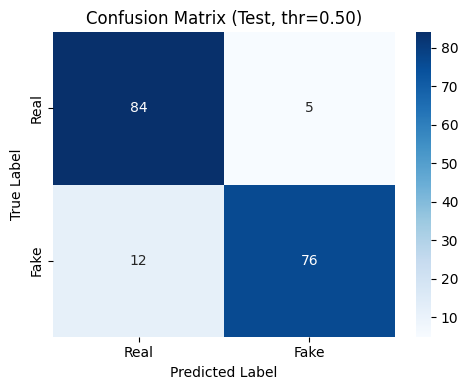

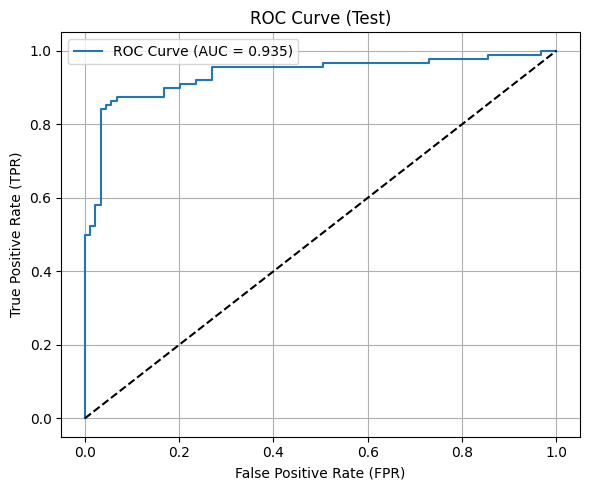


📊 Final Test Results Summary:
  Metric    Value
Accuracy 0.903955
F1-score 0.899408
     AUC 0.935010
BCE Loss 0.392977


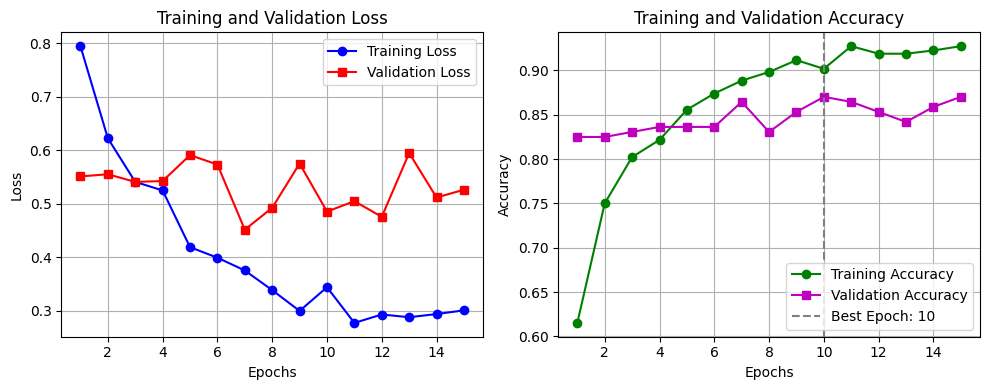

In [ ]:
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

try:
    _ = iter(val_loader)
except Exception:
    from torch.utils.data import DataLoader
    val_dataset = VideoDataset("/content/dataset/val")
    val_loader  = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2)

try:
    _ = iter(test_loader)
except Exception:
    from torch.utils.data import DataLoader
    test_dataset = VideoDataset("/content/dataset/test")
    test_loader  = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2)

val_results  = evaluate(model, val_loader,  criterion, device)
test_results = evaluate(model, test_loader, criterion, device)

val_probs   = np.array(val_results['probs'])
val_labels  = np.array(val_results['labels'])
test_probs  = np.array(test_results['probs'])
test_labels = np.array(test_results['labels'])

print(f"🧪 Test BCE Loss: {test_results['loss']:.4f}")

test_preds = (test_probs >= best_t).astype(int)

print("\n📄 Classification Report (Test):")
print(classification_report(test_labels, test_preds, target_names=["Real", "Fake"]))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label"); plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Test, thr={best_t:.2f})")
plt.tight_layout(); plt.show()

if len(np.unique(test_labels)) == 2:
    fpr, tpr, _ = roc_curve(test_labels, test_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate (FPR)"); plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve (Test)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    roc_auc = float('nan')
    print("⚠️ Test set has a single class; ROC/AUC not computed.")

test_acc = accuracy_score(test_labels, test_preds)
test_f1  = f1_score(test_labels, test_preds)
test_auc = roc_auc_score(test_labels, test_probs) if len(np.unique(test_labels)) == 2 else float('nan')
test_bce = float(test_results['loss'])

summary_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1-score", "AUC", "BCE Loss"],
    "Value":  [test_acc,   test_f1,    test_auc, test_bce]
})
print("\n📊 Final Test Results Summary:")
print(summary_df.to_string(index=False))

summary_df.to_csv("/content/drive/MyDrive/M2TR-dataset/baseline-run_summary.csv", index=False)

try:
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
except Exception as e:
    print("⚠️ plot_metrics was not executed. Reason:", e)

# + Contrastive Loss

In [ ]:
num_epochs = 15
best_val_auc = 0.0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\n📘 Epoch {epoch+1}/{num_epochs} — LR: {optimizer.param_groups[0]['lr']:.6f}")

    # 🚀 Train
    train_metrics = train_one_epoch(
        model, train_loader, criterion, optimizer, device,
        epoch,
        contrastive_weight=0.05  # ← Enable contrastive warm-up: add contrastive loss to main loss with a small weight (0.05).
                                 #    Inside train_one_epoch it's applied only for the first 3 epochs (epoch < 3).
    )
    val_metrics = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_metrics["loss"])
    val_losses.append(val_metrics["loss"])
    train_accs.append(train_metrics["acc"])
    val_accs.append(val_metrics["acc"])

    print(f"  🔹 Train Loss: {train_metrics['loss']:.4f} | Acc: {train_metrics['acc']:.4f}")
    print(f"  🔸 Val   Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['acc']:.4f}")

    if epoch < 3 and train_metrics["contrastive_loss"] is not None:
        # ← Only during the warm-up phase (first 3 epochs), we compute and report the average contrastive loss.
        print(f"     ⤷ Contrastive loss: {train_metrics['contrastive_loss']:.4f}")

    val_auc = roc_auc_score(val_metrics["labels"], val_metrics["probs"])
    print(f"  🔸 Val   AUC : {val_auc:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), "best_model_cont.pth")
        print("✅ Best model saved (by AUC).")

    torch.cuda.empty_cache()
    gc.collect()


📘 Epoch 1/15 — LR: 0.000100
  🔹 Train Loss: 0.8828 | Acc: 0.5704
  🔸 Val   Loss: 0.6310 | Acc: 0.7006
     ⤷ Contrastive loss: 0.3553
  🔸 Val   AUC : 0.7778
✅ Best model saved (by AUC).

📘 Epoch 2/15 — LR: 0.000100
  🔹 Train Loss: 0.7162 | Acc: 0.6699
  🔸 Val   Loss: 0.5910 | Acc: 0.7345
     ⤷ Contrastive loss: 0.3956
  🔸 Val   AUC : 0.7819
✅ Best model saved (by AUC).

📘 Epoch 3/15 — LR: 0.000100
  🔹 Train Loss: 0.6939 | Acc: 0.6917
  🔸 Val   Loss: 0.6250 | Acc: 0.7514
     ⤷ Contrastive loss: 0.2307
  🔸 Val   AUC : 0.8216
✅ Best model saved (by AUC).

📘 Epoch 4/15 — LR: 0.000100
  🔹 Train Loss: 0.6269 | Acc: 0.7197
  🔸 Val   Loss: 0.5781 | Acc: 0.7910
  🔸 Val   AUC : 0.8878
✅ Best model saved (by AUC).

📘 Epoch 5/15 — LR: 0.000100
  🔹 Train Loss: 0.5485 | Acc: 0.7731
  🔸 Val   Loss: 0.4244 | Acc: 0.8644
  🔸 Val   AUC : 0.8998
✅ Best model saved (by AUC).

📘 Epoch 6/15 — LR: 0.000100
  🔹 Train Loss: 0.5097 | Acc: 0.7998
  🔸 Val   Loss: 0.4221 | Acc: 0.8644
  🔸 Val   AUC : 0.9159
✅ B

🧪 Test BCE Loss: 0.3053

📄 Classification Report (Test):
              precision    recall  f1-score   support

        Real       0.88      0.94      0.91        89
        Fake       0.94      0.86      0.90        88

    accuracy                           0.90       177
   macro avg       0.91      0.90      0.90       177
weighted avg       0.91      0.90      0.90       177



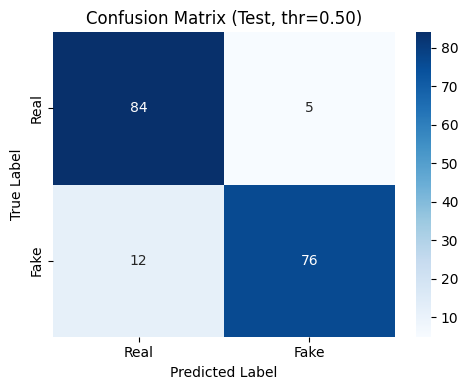

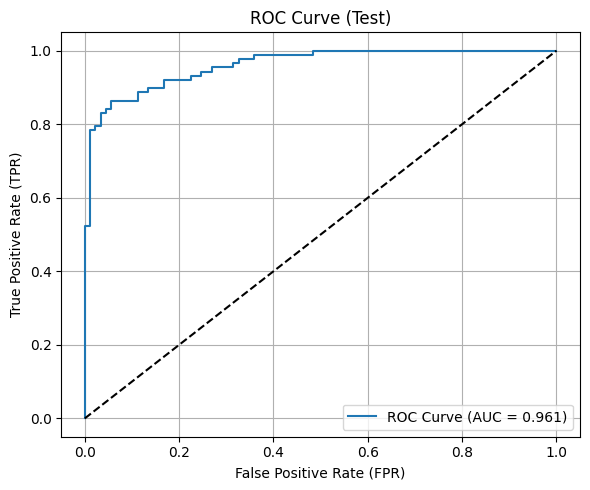


📊 Final Test Results Summary:
  Metric    Value
Accuracy 0.903955
F1-score 0.899408
     AUC 0.960674
BCE Loss 0.305271


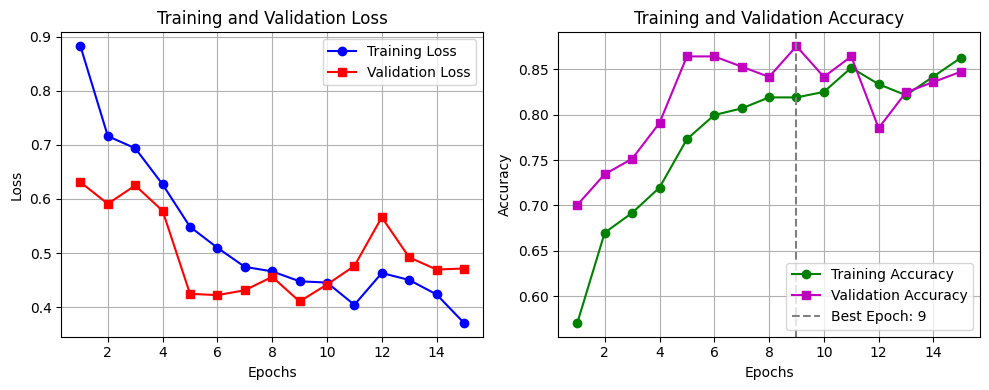

In [ ]:
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

try:
    _ = iter(val_loader)
except Exception:
    from torch.utils.data import DataLoader
    val_dataset = VideoDataset("/content/dataset/val")
    val_loader  = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2)

try:
    _ = iter(test_loader)
except Exception:
    from torch.utils.data import DataLoader
    test_dataset = VideoDataset("/content/dataset/test")
    test_loader  = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2)

val_results  = evaluate(model, val_loader,  criterion, device)
test_results = evaluate(model, test_loader, criterion, device)

val_probs   = np.array(val_results['probs'])
val_labels  = np.array(val_results['labels'])
test_probs  = np.array(test_results['probs'])
test_labels = np.array(test_results['labels'])

best_t = 0.50
print(f"🧪 Test BCE Loss: {test_results['loss']:.4f}")

test_preds = (test_probs >= best_t).astype(int)

print("\n📄 Classification Report (Test):")
print(classification_report(test_labels, test_preds, target_names=["Real", "Fake"]))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label"); plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Test, thr={best_t:.2f})")
plt.tight_layout(); plt.show()

if len(np.unique(test_labels)) == 2:
    fpr, tpr, _ = roc_curve(test_labels, test_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')  # random chance line
    plt.xlabel("False Positive Rate (FPR)"); plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve (Test)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    roc_auc = float('nan')
    print("⚠️ Test set has a single class; ROC/AUC not computed.")

test_acc = accuracy_score(test_labels, test_preds)
test_f1  = f1_score(test_labels, test_preds)
test_auc = roc_auc_score(test_labels, test_probs) if len(np.unique(test_labels)) == 2 else float('nan')
test_bce = float(test_results['loss'])

summary_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1-score", "AUC", "BCE Loss"],
    "Value":  [test_acc,   test_f1,    test_auc, test_bce]
})
print("\n📊 Final Test Results Summary:")
print(summary_df.to_string(index=False))

summary_df.to_csv("/content/drive/MyDrive/M2TR-dataset/baseline-run_summary.csv", index=False)

try:
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
except Exception as e:
    print("⚠️ plot_metrics was not executed. Reason:", e)

# + Dynamic Learning Rate

In [ ]:
num_epochs = 15
best_val_auc = 0.0

# Dynamic LR: Reduce learning rate when validation AUC plateaus.
# mode='max' → higher AUC is better; factor=0.5 halves LR; patience=2 waits 2 epochs without improvement.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\n📘 Epoch {epoch+1}/{num_epochs} — LR: {optimizer.param_groups[0]['lr']:.6f}")

    # 🚀 Train
    train_metrics = train_one_epoch(
        model, train_loader, criterion, optimizer, device,
        epoch,
        contrastive_weight=0.05  # Contrastive warm-up: add a small-weight contrastive loss to the main loss.
                                 # (Applied inside train_one_epoch only for the first 3 epochs: epoch < 3)
    )
    val_metrics = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_metrics["loss"])
    val_losses.append(val_metrics["loss"])
    train_accs.append(train_metrics["acc"])
    val_accs.append(val_metrics["acc"])

    print(f"  🔹 Train Loss: {train_metrics['loss']:.4f} | Acc: {train_metrics['acc']:.4f}")
    print(f"  🔸 Val   Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['acc']:.4f}")

    if epoch < 3 and train_metrics["contrastive_loss"] is not None:
        # Report contrastive loss during the warm-up phase (first 3 epochs).
        print(f"     ⤷ Contrastive loss: {train_metrics['contrastive_loss']:.4f}")

    val_auc = roc_auc_score(val_metrics["labels"], val_metrics["probs"])
    print(f"  🔸 Val   AUC : {val_auc:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), "best_model_cont_DLR.pth")
        print("✅ Best model saved (by AUC).")

    # Dynamic LR step: update LR based on validation AUC.
    # If AUC hasn't improved for 'patience' epochs, LR is reduced by 'factor'.
    scheduler.step(val_auc)
    print(f"  🔻 LR now: {optimizer.param_groups[0]['lr']:.6f}")

    torch.cuda.empty_cache()
    gc.collect()


📘 Epoch 1/15 — LR: 0.000100
  🔹 Train Loss: 0.8637 | Acc: 0.5243
  🔸 Val   Loss: 0.6236 | Acc: 0.6893
     ⤷ Contrastive loss: 0.2598
  🔸 Val   AUC : 0.7958
✅ Best model saved (by AUC).
  🔻 LR now: 0.000100

📘 Epoch 2/15 — LR: 0.000100
  🔹 Train Loss: 0.6972 | Acc: 0.7039
  🔸 Val   Loss: 0.5042 | Acc: 0.7966
     ⤷ Contrastive loss: 0.2659
  🔸 Val   AUC : 0.8358
✅ Best model saved (by AUC).
  🔻 LR now: 0.000100

📘 Epoch 3/15 — LR: 0.000100
  🔹 Train Loss: 0.6377 | Acc: 0.7342
  🔸 Val   Loss: 0.6918 | Acc: 0.7401
     ⤷ Contrastive loss: 0.1780
  🔸 Val   AUC : 0.8414
✅ Best model saved (by AUC).
  🔻 LR now: 0.000100

📘 Epoch 4/15 — LR: 0.000100
  🔹 Train Loss: 0.5742 | Acc: 0.7876
  🔸 Val   Loss: 0.4097 | Acc: 0.8418
  🔸 Val   AUC : 0.8921
✅ Best model saved (by AUC).
  🔻 LR now: 0.000100

📘 Epoch 5/15 — LR: 0.000100
  🔹 Train Loss: 0.5288 | Acc: 0.7925
  🔸 Val   Loss: 0.7025 | Acc: 0.8305
  🔸 Val   AUC : 0.8936
✅ Best model saved (by AUC).
  🔻 LR now: 0.000100

📘 Epoch 6/15 — LR: 0.00

🧪 Test BCE Loss: 0.3483

📄 Classification Report (Test):
              precision    recall  f1-score   support

        Real       0.89      0.96      0.92        89
        Fake       0.95      0.88      0.91        88

    accuracy                           0.92       177
   macro avg       0.92      0.92      0.92       177
weighted avg       0.92      0.92      0.92       177



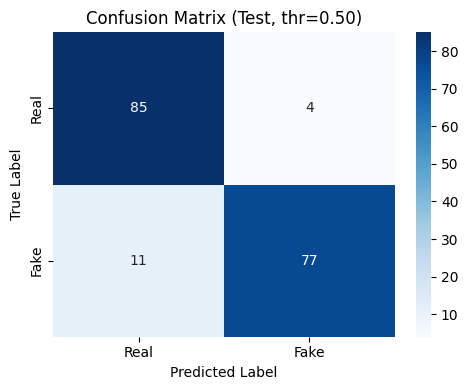

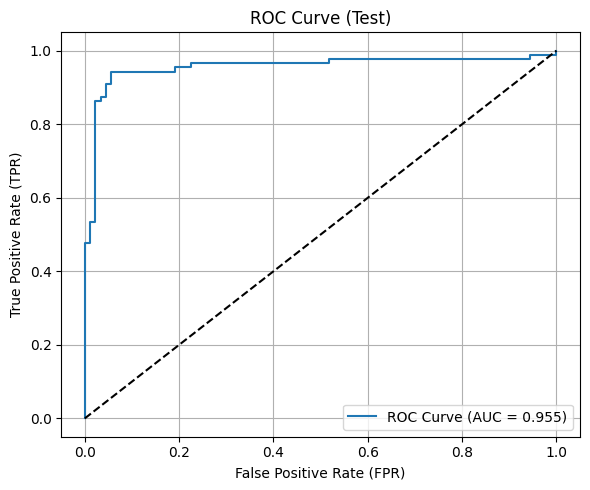


📊 Final Test Results Summary:
  Metric    Value
Accuracy 0.915254
F1-score 0.911243
     AUC 0.955439
BCE Loss 0.348337


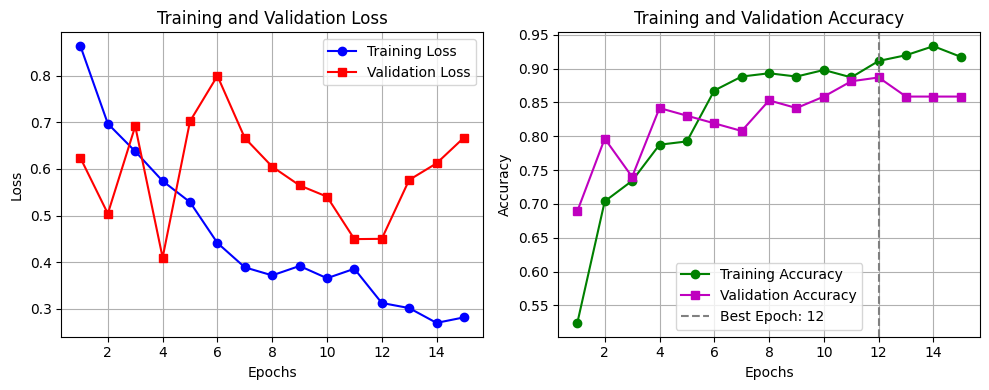

In [ ]:
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

try:
    _ = iter(val_loader)
except Exception:
    from torch.utils.data import DataLoader
    val_dataset = VideoDataset("/content/dataset/val")
    val_loader  = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2)

try:
    _ = iter(test_loader)
except Exception:
    from torch.utils.data import DataLoader
    test_dataset = VideoDataset("/content/dataset/test")
    test_loader  = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2)

val_results  = evaluate(model, val_loader,  criterion, device)
test_results = evaluate(model, test_loader, criterion, device)

val_probs   = np.array(val_results['probs'])
val_labels  = np.array(val_results['labels'])
test_probs  = np.array(test_results['probs'])
test_labels = np.array(test_results['labels'])

best_t = 0.50
print(f"🧪 Test BCE Loss: {test_results['loss']:.4f}")

test_preds = (test_probs >= best_t).astype(int)

print("\n📄 Classification Report (Test):")
print(classification_report(test_labels, test_preds, target_names=["Real", "Fake"]))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label"); plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Test, thr={best_t:.2f})")
plt.tight_layout(); plt.show()

if len(np.unique(test_labels)) == 2:
    fpr, tpr, _ = roc_curve(test_labels, test_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate (FPR)"); plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve (Test)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    roc_auc = float('nan')
    print("⚠️ Test set has a single class; ROC/AUC not computed.")

test_acc = accuracy_score(test_labels, test_preds)
test_f1  = f1_score(test_labels, test_preds)
test_auc = roc_auc_score(test_labels, test_probs) if len(np.unique(test_labels)) == 2 else float('nan')
test_bce = float(test_results['loss'])

summary_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1-score", "AUC", "BCE Loss"],
    "Value":  [test_acc,   test_f1,    test_auc, test_bce]
})
print("\n📊 Final Test Results Summary:")
print(summary_df.to_string(index=False))

summary_df.to_csv("/content/drive/MyDrive/M2TR-dataset/baseline-run_summary.csv", index=False)

try:
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
except Exception as e:
    print("⚠️ plot_metrics was not executed. Reason:", e)

# + Early Stopping

In [ ]:

num_epochs = 15
patience = 5              # Early stopping: stop if AUC doesn't improve for 'patience' epochs
wait = 0                  # Early stopping counter: number of epochs without AUC improvement
best_val_auc = 0.0

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\n📘 Epoch {epoch+1}/{num_epochs} — LR: {optimizer.param_groups[0]['lr']:.6f}")

    # 🚀 Train
    train_one_epoch_kwargs = dict(
        model=model,
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epoch=epoch,
        contrastive_weight=0.05  # Contrastive warm-up: add a small-weight contrastive loss to the main loss (applied inside train_one_epoch for first 3 epochs)
    )
    train_metrics = train_one_epoch(**train_one_epoch_kwargs)
    val_metrics = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_metrics["loss"])
    val_losses.append(val_metrics["loss"])
    train_accs.append(train_metrics["acc"])
    val_accs.append(val_metrics["acc"])

    print(f"  🔹 Train Loss: {train_metrics['loss']:.4f} | Acc: {train_metrics['acc']:.4f}")
    print(f"  🔸 Val   Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['acc']:.4f}")

    if epoch < 3:
        # Report the contrastive loss only during the warm-up phase (first 3 epochs)
        print(f"     ⤷ Contrastive loss: {train_metrics['contrastive_loss']:.4f}")

    val_auc = roc_auc_score(val_metrics["labels"], val_metrics["probs"])
    print(f"  🔸 Val   AUC : {val_auc:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), "best_model_cont_DLR_early.pth")
        print("✅ Best model saved (by AUC).")
        wait = 0  # Early stopping: reset counter when AUC improves
    else:
        wait += 1
        print(f"  ⏳ No AUC improvement. Wait: {wait}/{patience}")  # Early stopping: increment counter when no improvement

    # 📉 Dynamic LR step: reduce LR when AUC plateaus (handled by ReduceLROnPlateau)
    scheduler.step(val_auc)

    # 🛑 Early stopping: stop training if no improvement for 'patience' epochs
    if wait >= patience:
        print("⏹ Early stopping triggered.")
        break

    torch.cuda.empty_cache()
    gc.collect()


📘 Epoch 1/15 — LR: 0.000100
  🔹 Train Loss: 0.8163 | Acc: 0.5825
  🔸 Val   Loss: 0.5645 | Acc: 0.7627
     ⤷ Contrastive loss: 0.3084
  🔸 Val   AUC : 0.8243
✅ Best model saved (by AUC).

📘 Epoch 2/15 — LR: 0.000100
  🔹 Train Loss: 0.7219 | Acc: 0.7002
  🔸 Val   Loss: 0.5924 | Acc: 0.7627
     ⤷ Contrastive loss: 0.2914
  🔸 Val   AUC : 0.8408
✅ Best model saved (by AUC).

📘 Epoch 3/15 — LR: 0.000100
  🔹 Train Loss: 0.6427 | Acc: 0.7379
  🔸 Val   Loss: 0.4746 | Acc: 0.8023
     ⤷ Contrastive loss: 0.2425
  🔸 Val   AUC : 0.8690
✅ Best model saved (by AUC).

📘 Epoch 4/15 — LR: 0.000100
  🔹 Train Loss: 0.5968 | Acc: 0.7476
  🔸 Val   Loss: 0.5068 | Acc: 0.7853
  🔸 Val   AUC : 0.8793
✅ Best model saved (by AUC).

📘 Epoch 5/15 — LR: 0.000100
  🔹 Train Loss: 0.5025 | Acc: 0.8107
  🔸 Val   Loss: 0.5188 | Acc: 0.8475
  🔸 Val   AUC : 0.8889
✅ Best model saved (by AUC).

📘 Epoch 6/15 — LR: 0.000100
  🔹 Train Loss: 0.5268 | Acc: 0.7961
  🔸 Val   Loss: 0.7165 | Acc: 0.7684
  🔸 Val   AUC : 0.8223
  ⏳

🧪 Test BCE Loss: 0.3571

📄 Classification Report (Test):
              precision    recall  f1-score   support

        Real       0.84      0.94      0.89        89
        Fake       0.94      0.82      0.87        88

    accuracy                           0.88       177
   macro avg       0.89      0.88      0.88       177
weighted avg       0.89      0.88      0.88       177



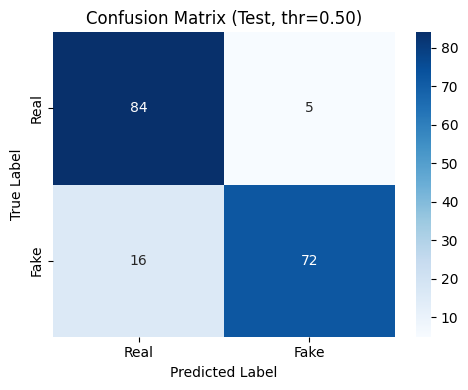

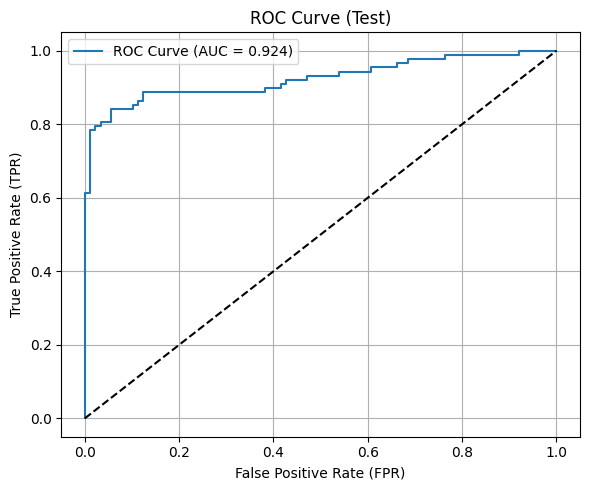


📊 Final Test Results Summary:
  Metric    Value
Accuracy 0.881356
F1-score 0.872727
     AUC 0.923519
BCE Loss 0.357097


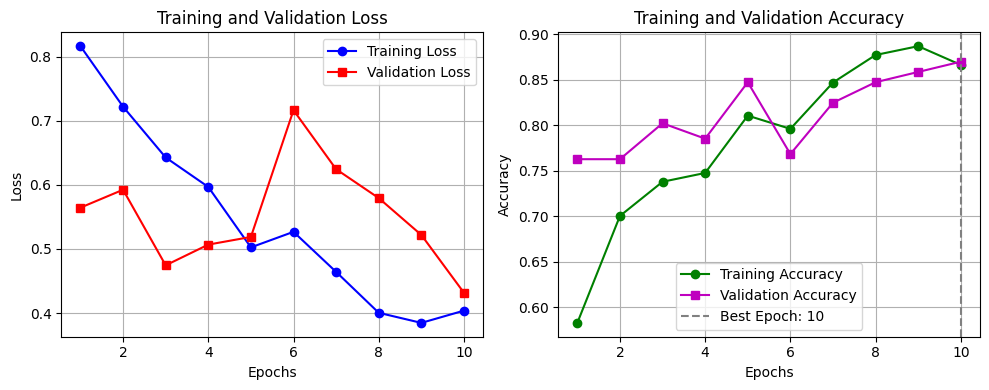

In [ ]:
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

try:
    _ = iter(val_loader)
except Exception:
    from torch.utils.data import DataLoader
    val_dataset = VideoDataset("/content/dataset/val")
    val_loader  = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2)

try:
    _ = iter(test_loader)
except Exception:
    from torch.utils.data import DataLoader
    test_dataset = VideoDataset("/content/dataset/test")
    test_loader  = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2)

val_results  = evaluate(model, val_loader,  criterion, device)
test_results = evaluate(model, test_loader, criterion, device)

val_probs   = np.array(val_results['probs'])
val_labels  = np.array(val_results['labels'])
test_probs  = np.array(test_results['probs'])
test_labels = np.array(test_results['labels'])

best_t = 0.50
print(f"🧪 Test BCE Loss: {test_results['loss']:.4f}")

test_preds = (test_probs >= best_t).astype(int)

print("\n📄 Classification Report (Test):")
print(classification_report(test_labels, test_preds, target_names=["Real", "Fake"]))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label"); plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Test, thr={best_t:.2f})")
plt.tight_layout(); plt.show()

if len(np.unique(test_labels)) == 2:
    fpr, tpr, _ = roc_curve(test_labels, test_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate (FPR)"); plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve (Test)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    roc_auc = float('nan')
    print("⚠️ Test set has a single class; ROC/AUC not computed.")

test_acc = accuracy_score(test_labels, test_preds)
test_f1  = f1_score(test_labels, test_preds)
test_auc = roc_auc_score(test_labels, test_probs) if len(np.unique(test_labels)) == 2 else float('nan')
test_bce = float(test_results['loss'])

summary_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1-score", "AUC", "BCE Loss"],
    "Value":  [test_acc,   test_f1,    test_auc, test_bce]
})
print("\n📊 Final Test Results Summary:")
print(summary_df.to_string(index=False))

summary_df.to_csv("/content/drive/MyDrive/M2TR-dataset/baseline-run_summary.csv", index=False)

try:
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
except Exception as e:
    print("⚠️ plot_metrics was not executed. Reason:", e)

# + Threshold Tuning

⭐ Best threshold on Val: 0.050 (F1 fine (raw)) | Val F1=0.8652
🧪 Test BCE Loss: 0.3483

📄 Classification Report (Test):
              precision    recall  f1-score   support

        Real       0.89      0.96      0.92        89
        Fake       0.95      0.89      0.92        88

    accuracy                           0.92       177
   macro avg       0.92      0.92      0.92       177
weighted avg       0.92      0.92      0.92       177



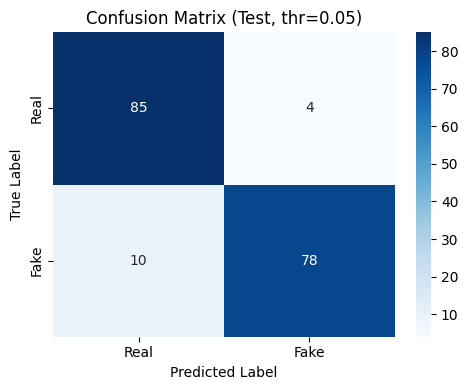

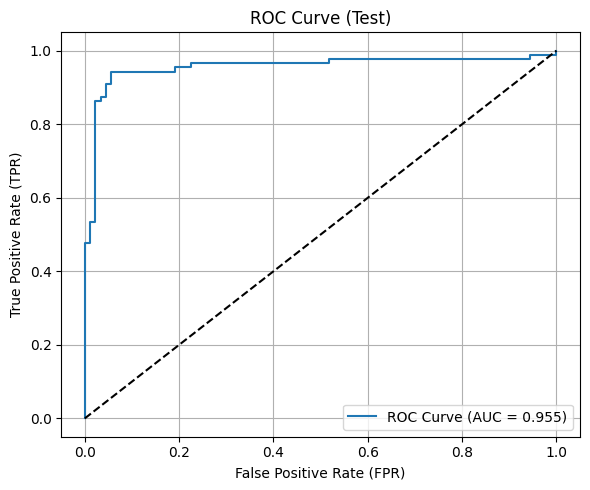


📊 Final Test Results Summary:
  Metric    Value
Accuracy 0.920904
F1-score 0.917647
     AUC 0.955439
BCE Loss 0.348337


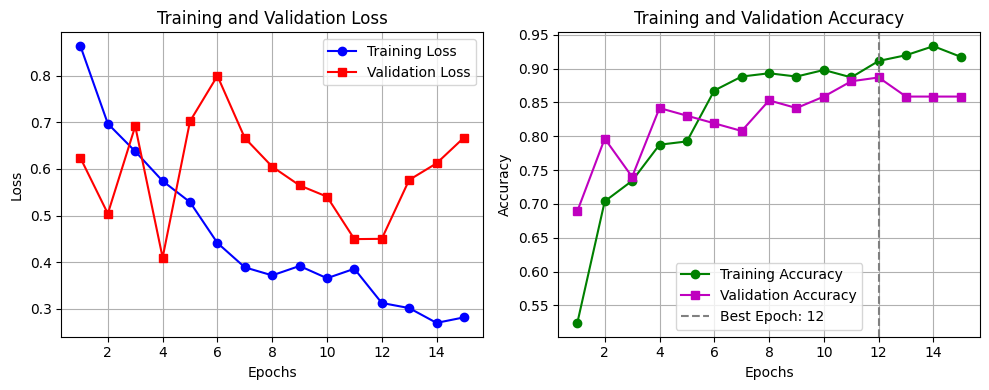

In [ ]:
model.load_state_dict(torch.load("best_model_cont_DLR.pth", map_location=device))
model.eval()

try:
    _ = iter(val_loader)
except Exception:
    from torch.utils.data import DataLoader
    val_dataset = VideoDataset("/content/dataset/val")
    val_loader  = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2)

try:
    _ = iter(test_loader)
except Exception:
    from torch.utils.data import DataLoader
    test_dataset = VideoDataset("/content/dataset/test")
    test_loader  = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2)

def collect_logits_labels(model, loader, device):
    # Collect raw logits and labels for threshold tuning (we'll apply sigmoid later)
    model.eval()
    all_logits, all_labels = [], []
    with torch.no_grad():
        for rgb, fft, labels in loader:
            rgb, fft = rgb.to(device), fft.to(device)
            logits = model(rgb, fft)  # raw logits (no sigmoid)
            all_logits.append(logits.detach())
            all_labels.append(labels.float().to(device))
    return torch.cat(all_logits), torch.cat(all_labels)

val_logits,  val_y  = collect_logits_labels(model, val_loader,  device)
test_logits, test_y = collect_logits_labels(model, test_loader, device)

bceloss = nn.BCEWithLogitsLoss()
with torch.no_grad():
    # Convert logits → probabilities for threshold search/evaluation
    val_probs   = torch.sigmoid(val_logits).cpu().numpy()
    val_labels  = val_y.cpu().numpy()
    test_probs  = torch.sigmoid(test_logits).cpu().numpy()
    test_labels = test_y.cpu().numpy()
    test_bce    = bceloss(test_logits, test_y).item()

# Threshold tuning on Validation to maximize F1 (coarse search → fine search)
if len(np.unique(val_labels)) < 2:
    # Fallback when val set has a single class: use default 0.50
    best_t  = 0.50
    best_f1 = f1_score(val_labels, (val_probs >= 0.5).astype(int))
    src     = "fixed 0.50 (single-class val)"
else:
    # Coarse scan to find a good region
    coarse_ths = np.linspace(0.15, 0.45, 31)
    coarse_f1s = [f1_score(val_labels, (val_probs >= t).astype(int)) for t in coarse_ths]
    t_coarse   = float(coarse_ths[int(np.argmax(coarse_f1s))])

    # Fine scan around the coarse best to refine the threshold
    fine_low, fine_high = max(0.0, t_coarse - 0.10), min(1.0, t_coarse + 0.10)
    fine_ths   = np.linspace(fine_low, fine_high, 81)
    fine_f1s   = [f1_score(val_labels, (val_probs >= t).astype(int)) for t in fine_ths]
    best_t     = float(fine_ths[int(np.argmax(fine_f1s))])
    best_f1    = float(np.max(fine_f1s))
    src        = "F1 fine (raw)"

print(f"⭐ Best threshold on Val: {best_t:.3f} ({src}) | Val F1={best_f1:.4f}")
print(f"🧪 Test BCE Loss: {test_bce:.4f}")

# Apply the tuned threshold to Test probabilities to get final predictions
test_preds = (test_probs >= best_t).astype(int)

print("\n📄 Classification Report (Test):")
print(classification_report(test_labels, test_preds, target_names=["Real", "Fake"]))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label"); plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Test, thr={best_t:.2f})")
plt.tight_layout(); plt.show()

if len(np.unique(test_labels)) == 2:
    fpr, tpr, _ = roc_curve(test_labels, test_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate (FPR)"); plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve (Test)"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    roc_auc = float('nan')
    print("⚠️ Test set has a single class; ROC/AUC not computed.")

test_acc = accuracy_score(test_labels, test_preds)
test_f1  = f1_score(test_labels, test_preds)
test_auc = roc_auc_score(test_labels, test_probs) if len(np.unique(test_labels))==2 else float('nan')

summary_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1-score", "AUC", "BCE Loss"],
    "Value":  [test_acc,   test_f1,    test_auc, test_bce]
})
print("\n📊 Final Test Results Summary:")
print(summary_df.to_string(index=False))

try:
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
except Exception as e:
    print("⚠️ plot_metrics was not executed. Reason:", e)

summary_df.to_csv("/content/drive/MyDrive/M2TR-dataset/cont_DLR_threshold_summary.csv", index=False)

flips 0→1: 1  | 1→0: 0


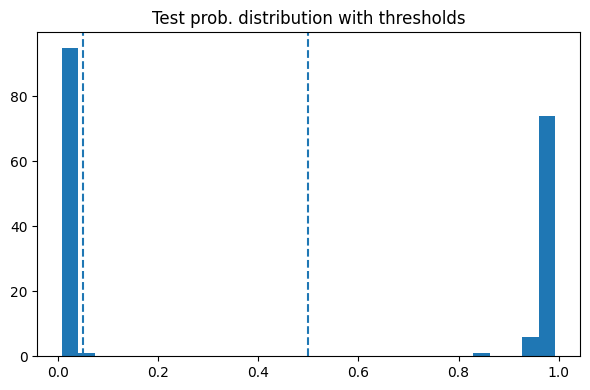

In [ ]:
# Count how many predictions change when using the tuned threshold instead of 0.50
pred05 = (test_probs >= 0.50).astype(int)
predt  = (test_probs >= best_t).astype(int)
print("flips 0→1:", int(((pred05==0)&(predt==1)).sum()),
      " | 1→0:", int(((pred05==1)&(predt==0)).sum()))

# Plot histogram of test probabilities and draw both thresholds
plt.figure(figsize=(6,4))
plt.hist(test_probs, bins=30)          # distribution of predicted probabilities
plt.axvline(0.50, linestyle="--")      # default threshold
plt.axvline(best_t, linestyle="--")    # tuned threshold
plt.title("Test prob. distribution with thresholds")
plt.tight_layout()
plt.show()

# + Tempreature Scaling

🌡 Learned temperature T = 2.298
⭐ Best threshold on Val: 0.120 (F1 fine (with TS)) | Val F1=0.8995
🧪 Test BCE Loss (with TS): 0.2858

📄 Classification Report (Test):
              precision    recall  f1-score   support

        Real       0.94      0.90      0.92        89
        Fake       0.90      0.94      0.92        88

    accuracy                           0.92       177
   macro avg       0.92      0.92      0.92       177
weighted avg       0.92      0.92      0.92       177



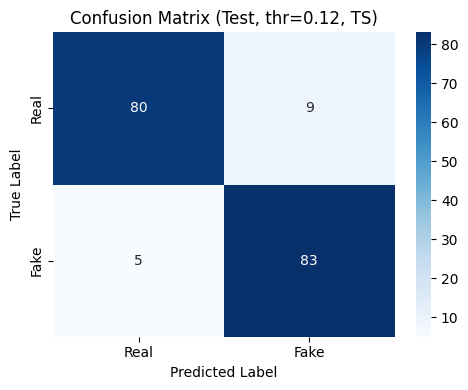

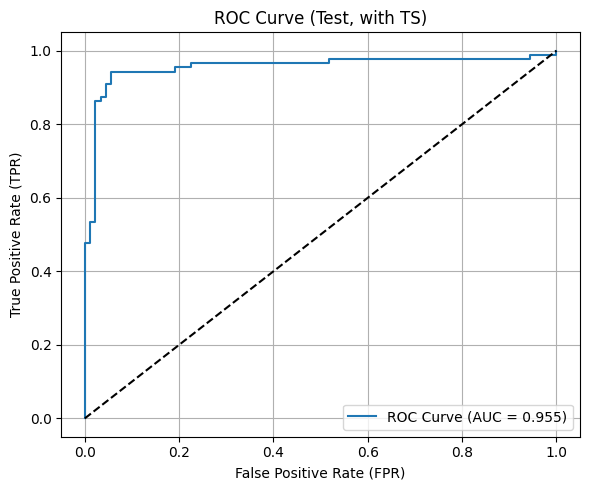


📊 Final Test Results Summary (with Temperature Scaling):
       Metric    Value
     Accuracy 0.920904
     F1-score 0.922222
          AUC 0.955439
BCE Loss (TS) 0.285789
  Temperature 2.297955


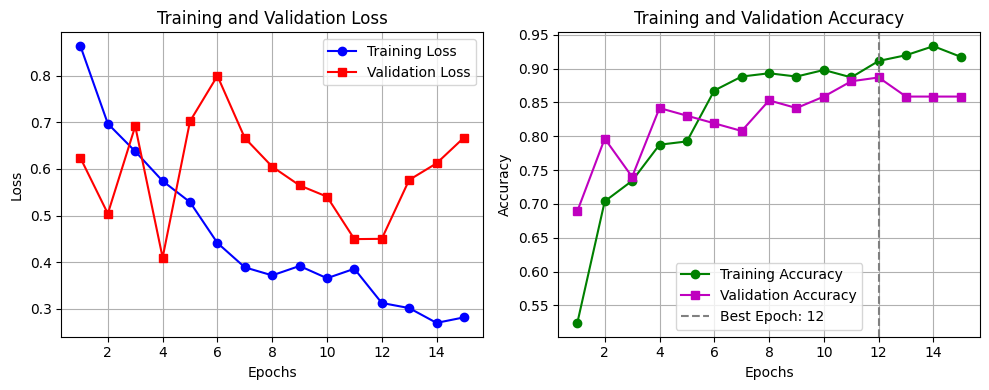

In [ ]:
model.load_state_dict(torch.load("best_model_cont_DLR.pth", map_location=device))
model.eval()

try:
    _ = iter(val_loader)
except Exception:
    from torch.utils.data import DataLoader
    val_dataset = VideoDataset("/content/dataset/val")
    val_loader  = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2)

try:
    _ = iter(test_loader)
except Exception:
    from torch.utils.data import DataLoader
    test_dataset = VideoDataset("/content/dataset/test")
    test_loader  = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2)

# Threshold Tuning & Temperature Scaling: collect raw logits (no sigmoid) for calibration/search
def collect_logits_labels(model, loader, device):
    model.eval()
    all_logits, all_labels = [], []
    with torch.no_grad():
        for rgb, fft, labels in loader:
            rgb, fft = rgb.to(device), fft.to(device)
            logits = model(rgb, fft)  # raw logits
            all_logits.append(logits.detach())
            all_labels.append(labels.float().to(device))
    return torch.cat(all_logits), torch.cat(all_labels)

val_logits,  val_y  = collect_logits_labels(model, val_loader,  device)
test_logits, test_y = collect_logits_labels(model, test_loader, device)

# Temperature Scaling: optimize logT on validation so T=exp(logT)>0 and BCE is minimized
logT = nn.Parameter(torch.zeros((), device=device))  # start with T=1.0
optT = torch.optim.Adam([logT], lr=0.01)
bceloss = nn.BCEWithLogitsLoss()
for _ in range(500):
    optT.zero_grad()
    T = torch.exp(logT)
    scaled_val_logits = val_logits / T.clamp(min=1e-3)
    loss = bceloss(scaled_val_logits, val_y)
    loss.backward()
    optT.step()

T_star = float(torch.exp(logT).detach().cpu().item())
print(f"🌡 Learned temperature T = {T_star:.3f}")

# Apply learned temperature: scale logits then convert to probabilities
with torch.no_grad():
    val_probs   = torch.sigmoid(val_logits  / max(T_star, 1e-3)).cpu().numpy()
    val_labels  = val_y.cpu().numpy()
    test_probs  = torch.sigmoid(test_logits / max(T_star, 1e-3)).cpu().numpy()
    test_labels = test_y.cpu().numpy()
    test_bce    = bceloss(test_logits / max(T_star, 1e-3), test_y).item()

# Threshold Tuning (Validation): pick threshold that maximizes F1 (coarse search → fine search)
if len(np.unique(val_labels)) < 2:
    best_t  = 0.50  # fallback if validation has a single class
    best_f1 = f1_score(val_labels, (val_probs >= 0.5).astype(int))
    src     = "fixed 0.50 (single-class val)"
else:
    # coarse scan to find a good region
    coarse_ths = np.linspace(0.15, 0.45, 31)
    coarse_f1s = [f1_score(val_labels, (val_probs >= t).astype(int)) for t in coarse_ths]
    t_coarse   = float(coarse_ths[int(np.argmax(coarse_f1s))])

    # fine scan around the coarse best threshold
    fine_low, fine_high = max(0.0, t_coarse - 0.10), min(1.0, t_coarse + 0.10)
    fine_ths   = np.linspace(fine_low, fine_high, 81)
    fine_f1s   = [f1_score(val_labels, (val_probs >= t).astype(int)) for t in fine_ths]
    best_t     = float(fine_ths[int(np.argmax(fine_f1s))])
    best_f1    = float(np.max(fine_f1s))
    src        = "F1 fine (with TS)"

print(f"⭐ Best threshold on Val: {best_t:.3f} ({src}) | Val F1={best_f1:.4f}")
print(f"🧪 Test BCE Loss (with TS): {test_bce:.4f}")

test_preds = (test_probs >= best_t).astype(int)

print("\n📄 Classification Report (Test):")
print(classification_report(test_labels, test_preds, target_names=["Real", "Fake"]))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label"); plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Test, thr={best_t:.2f}, TS)")
plt.tight_layout(); plt.show()

if len(np.unique(test_labels)) == 2:
    fpr, tpr, _ = roc_curve(test_labels, test_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate (FPR)"); plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve (Test, with TS)"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    roc_auc = float('nan')
    print("⚠️ Test set has a single class; ROC/AUC not computed.")

test_acc = accuracy_score(test_labels, test_preds)
test_f1  = f1_score(test_labels, test_preds)
test_auc = roc_auc_score(test_labels, test_probs) if len(np.unique(test_labels))==2 else float('nan')

summary_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1-score", "AUC", "BCE Loss (TS)", "Temperature"],
    "Value":  [test_acc,   test_f1,    test_auc, test_bce,      T_star]
})
print("\n📊 Final Test Results Summary (with Temperature Scaling):")
print(summary_df.to_string(index=False))

try:
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
except Exception as e:
    print("⚠️ plot_metrics was not executed. Reason:", e)

summary_df.to_csv("/content/drive/MyDrive/M2TR-dataset/cont_DLR_threshold_temp_summary.csv", index=False)